## 影片解讀

原理就是將影片的 frames 拆出來成為圖片，然後傳給 GPT-4V 解讀即可

參考自 https://github.com/openai/openai-cookbook/blob/main/examples/GPT_with_vision_for_video_understanding.ipynb

In [ ]:
from getpass import getpass
openai_api_key = getpass('請輸入你的 OpenAI API Key: ')

請輸入你的 OpenAI API Key: ··········


In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.3/220.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [ ]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video
import base64
import time
import openai
import os
import requests

In [ ]:
openai.api_key = openai_api_key

In [ ]:
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.5 MB/s eta 0:00:00


實測影片: https://www.youtube.com/watch?v=gFIZjGrBdbU

In [ ]:
# 下載影片
from pytube import YouTube
yt = YouTube('https://www.youtube.com/watch?v=gFIZjGrBdbU')
video = yt.streams.get_highest_resolution()

filename = video.download('/content/')

In [ ]:
filename

'/content/觀眾就是要等李多慧秀一段 還有開花舞呢 正面拋媚眼你醉了嗎 我們大家都醉了 猿氣在旁邊好可愛 20230815 이다혜 치어리더 공연！날 웃게하는 치어리더 직캠 fancam.mp4'

In [ ]:
# 把影片 frames 拆出來
video = cv2.VideoCapture(filename)

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

1574 frames read.


In [ ]:
# 每100張 frames 取一張，丟給 GPT-4V 解讀
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video. 請用台灣繁體中文回覆.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::100]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

result = openai.chat.completions.create(**params)
print(result.choices[0].message.content)

在球賽的激情中加入了一絲輕盈與歡笑，本視頻帶您見證一場萌趣十足的互動，看著我們活力四射的啦啦隊員與可愛的吉祥物在球場上展開的一系列趣味互動。跟隨他們的舞步，感受運動賽事中那份特別的歡樂元素吧！這場不僅有運動員的汗水，還有笑容與歡欣，保證讓您看得心情大好。別忘了點讚、分享，並訂


### 來配一個語音旁白

In [ ]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {openai_api_key}",
    },
    json={
        "model": "tts-1",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)

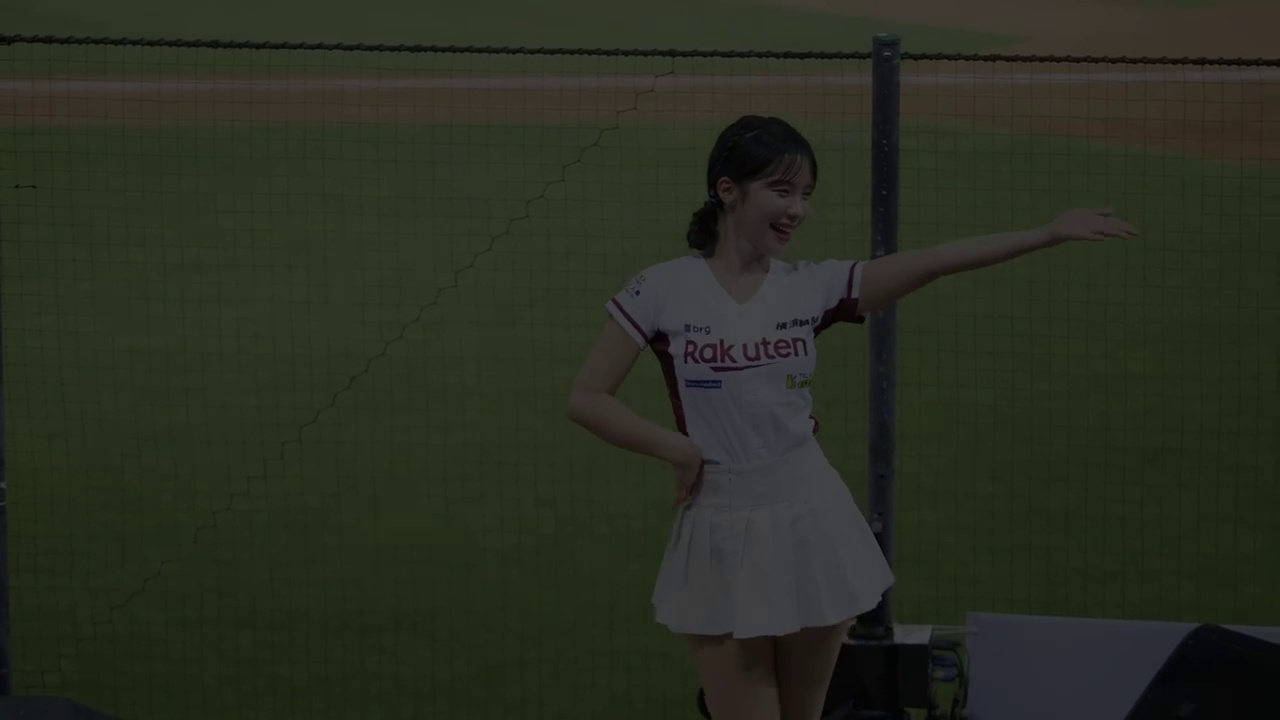

In [ ]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    # time.sleep(0.025)